In [3]:
pip install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 31.3 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
  Running setup.py install for box2d-py ... done
  DEPRECATION: box2d-py was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. pip 23.1 will enforce this behaviour change. A possible replacement is to fix the wheel build issue repo

In [6]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [7]:
env = gym.make('LunarLander-v2')
num_states = env.observation_space.shape[0]
num_actions = env.action_space.n
num_episodes = 1
gamma = 0.99
learning_rate = 0.001


In [8]:
class ActorCritic(tf.keras.Model):
    def __init__(self, num_actions):
        super().__init__()
        self.common = layers.Dense(32, activation="relu")
        self.actor = layers.Dense(num_actions, activation="softmax")
        self.critic = layers.Dense(1)

    def call(self, inputs):
        x = self.common(inputs)
        return self.actor(x), self.critic(x)

In [9]:
class QActorCriticAgent:
    def __init__(self, num_states, num_actions):
        self.num_states = num_states
        self.num_actions = num_actions
        self.model = ActorCritic(num_actions)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate)

    def act(self, state):
        state = np.expand_dims(state, axis=0)
        action_probs, _ = self.model.predict(state)
        action = np.random.choice(self.num_actions, p=np.squeeze(action_probs))
        return action

    def update(self, state, action, reward, next_state, done):
        state = np.expand_dims(state, axis=0)
        next_state = np.expand_dims(next_state, axis=0)

        _, critic_value = self.model.predict(state)
        _, next_critic_value = self.model.predict(next_state)

        target = reward + gamma * next_critic_value * (1 - int(done))
        td_error = target - critic_value

        with tf.GradientTape() as tape:
            action_probs, critic_value = self.model(state)
            _, next_critic_value = self.model(next_state)

            target = reward + gamma * next_critic_value * (1 - int(done))
            td_error = target - critic_value

            log_action_probs = tf.math.log(action_probs)
            log_prob = tf.reduce_sum(
                tf.one_hot(action, self.num_actions) * log_action_probs, axis=1
            )

            actor_loss = -tf.reduce_mean(log_prob * td_error)
            critic_loss = td_error ** 2
            total_loss = actor_loss + 0.5 * critic_loss

        grads = tape.gradient(total_loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))


In [10]:
agent = QActorCriticAgent(num_states, num_actions)
episode_rewards = []

for episode in range(num_episodes):
    state = env.reset()
    episode_reward = 0

    while True:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.update(state, action, reward, next_state, done)

        state = next_state
        episode_reward += reward

        if done:
            break

    episode_rewards.append(episode_reward)
    print(f"Episode {episode + 1}: reward = {episode_reward}")


Episode 1: reward = -151.32932131131858


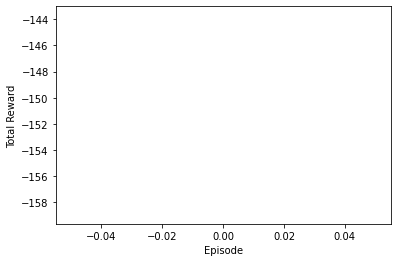

<Figure size 432x288 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt

plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.show()
plt.savefig('Total_Reward_QAC_Cartpole')

# Testing the agent for 20 Episodes (Agent choosing only greedy actions from the learnt policy)

Test episode 1: reward = -217.44186114144844


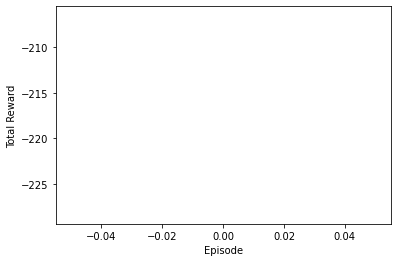

<Figure size 432x288 with 0 Axes>

In [12]:
test_episode_rewards = []

for episode in range(1):
    state = env.reset()
    episode_reward = 0

    while True:
        action_probs, _ = agent.model.predict(np.expand_dims(state, axis=0))
        action = np.argmax(action_probs)

        next_state, reward, done, _ = env.step(action)

        state = next_state
        episode_reward += reward

        if done:
            break

    test_episode_rewards.append(episode_reward)
    print(f"Test episode {episode + 1}: reward = {episode_reward}")

plt.plot(test_episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.show()
plt.savefig('Testing_Total_Reward_QAC_Cartpole')